In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:

train_data_path = "G:/PARAG_S/A1_part2/data/data/train.json"
test_data_path = "G:/PARAG_S/A1_part2/data/data/test.json"
val_data_path = "G:/PARAG_S/A1_part2/data/data/dev.json"
glove_path = "G:/NLP_assignment_2/glove.6B.100d.txt"


In [3]:

import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [2]:
import nltk
from nltk.tokenize import word_tokenize
import json
import torch
# nltk.download('punkt')


with open(train_data_path, 'r') as file:
    data = json.load(file)


with open(val_data_path, 'r') as file:
    val_data = json.load(file)



with open(test_data_path, 'r') as file:
    test_data = json.load(file)

for problem_data in data:
    problem = problem_data["Problem"]
    linear_formula = problem_data["linear_formula"]
    answer = problem_data["answer"]



from nltk.tokenize import word_tokenize

import re
from nltk.tokenize import word_tokenize



def tokenize_formula(formula):
    # Split the formula by '|'
    parts = formula.split('|')

    # Tokenize each part
    tokens = ['<sos>']
    for part in parts:
        if part: 
            open_parenthesis_index = part.find('(')
            if open_parenthesis_index != -1:
                function = part[:open_parenthesis_index]
                arguments = part[open_parenthesis_index+1:-1] 
                arguments_tokens = arguments.split(',')
                # print(arguments_tokens)
                arguments_token_new=[]
                for tok in arguments_tokens:
                    arguments_token_new.append(tok)
                    arguments_token_new.append(',')
                    #split the arguments by comma
                tokens.extend([function, '('] + arguments_token_new[:-1] + [')'])
            else:
                tokens.append(part)
        if tokens[-1] != '|':
            tokens.append('|')
    tokens.append("<eos>")

    return tokens






from collections import Counter
from nltk.tokenize import word_tokenize

def build_vocab(texts, is_formula=False):
    counter = Counter()
    for text in texts:
        if is_formula:
            tokens = tokenize_formula(text.lower())  
        else:
            tokens = word_tokenize(text.lower()) 
        counter.update(tokens)

    # Start the vocab with special tokens
    vocab = {"<pad>": 0, "<unk>": 1 , "<sos>":2, "<eos>":3 ,'<digit>':4}

    # If it's a formula, include <sos> and <eos> tokens
    # if is_formula:
    #     vocab["<sos>"] = len(vocab)
    #     vocab["<eos>"] = len(vocab)

   
    for word in counter:
        if word.isdigit():
          continue
        if word not in vocab:
            vocab[word] = len(vocab)

    return vocab, counter


# Separate problem texts and linear formulas
import numpy as np
problem_texts = [item["Problem"].lower() for item in data]
linear_formulas = [item["linear_formula"].lower() for item in data]

# Build vocabularies
problem_vocab, _ = build_vocab(problem_texts)
formula_vocab, _ = build_vocab(linear_formulas, is_formula=True)


# # Adding special tokens
# for vocab in (problem_vocab, formula_vocab):
#     vocab["<pad>"] = 0
#     vocab["<unk>"] = 1

# problem_vocab['<eos>'] = len(problem_vocab)
# formula_vocab = {key: value for key, value in formula_vocab.items() if not key.isdigit()}
# problem_vocab = {key: value for key, value in problem_vocab.items() if not key.isdigit()}

# def reindex_vocab(vocab):
#     """Reindex the vocabulary."""
#     new_vocab = {}
#     new_index = 0
#     for key in vocab.keys():
#         new_vocab[key] = new_index
#         new_index += 1
#     return new_vocab

# # Reindex vocabularies after filtering out digit keys
# problem_vocab = reindex_vocab(problem_vocab)
# formula_vocab = reindex_vocab(formula_vocab)

#     tokens = word_tokenize(text.lower())
#     return [vocab.get(token, vocab["<unk>"]) for token in tokens]

# tokenized_problems = [text_to_indices(problem, problem_vocab) for problem in problem_texts]
# tokenized_formulas = [text_to_indices(formula, formula_vocab) for formula in linear_formulas]



def load_glove_embeddings(glove_file):
    embeddings = {}
    with open(glove_file, 'r', encoding='utf8') as file:
        for line in file:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings[word] = vector
    return embeddings

# Load GloVe embeddings
glove_path = glove_path # Update this path
glove_embeddings = load_glove_embeddings(glove_path)

embedding_dim = 100
# embedding_matrix = np.zeros((len(problem_vocab)-1, embedding_dim))

# for word, idx in problem_vocab.items():
#     embedding_vector = glove_embeddings.get(word)
#     if embedding_vector is not None:
#         embedding_matrix[idx] = embedding_vector














# def load_glove_embeddings(glove_file, word_to_index, embedding_dim=50):
#     embeddings = {}
#     with open(glove_file, 'r', encoding='utf8') as file:
#         for line in file:
#             parts = line.split()
#             word = parts[0]
#             vector = np.array(parts[1:], dtype=np.float32)
#             embeddings[word] = vector

#     # The +1 here ensures there is a row in the matrix for every index in word_to_index
#     embedding_matrix = np.zeros((len(word_to_index)-1, embedding_dim))
#     for word, index in word_to_index.items():
#         if word in embeddings:
#             embedding_matrix[index] = embeddings[word]
#         else:
#             # It's common to initialize embeddings for unknown words with zeros or small random numbers
#             embedding_matrix[index] = np.random.normal(scale=0.6, size=(embedding_dim, ))

#     return embedding_matrix


# Adjust the path to your GloVe file and the embedding dimension you wish to use
# glove_path = "G:/NLP_assignment_2/glove.6B.100d.txt"
# embedding_matrix = load_glove_embeddings(glove_path, vocab, 50)

embedding_dim = 100  # Assuming you're using GloVe 50-dimensional embeddings

def create_embedding_matrix(vocab, embeddings, embedding_dim):
    embedding_matrix = np.zeros((len(vocab), embedding_dim))
    for word, idx in vocab.items():
        if word in embeddings:
            embedding_matrix[idx] = embeddings[word]
        else:
            embedding_matrix[idx] = np.random.rand(embedding_dim)  # Random embedding for unknown words
    return embedding_matrix


# Create embedding matrix for problem vocabulary
problem_embedding_matrix = create_embedding_matrix(problem_vocab, glove_embeddings, embedding_dim)
problem_embedding_matrix_tensor = torch.tensor(problem_embedding_matrix, dtype=torch.float)


torch.save(problem_embedding_matrix_tensor, 'problem_embedding_matrix_lstm_lstm.pt')






def text_to_indices(text, vocab):
    tokens = ['<sos>'] + word_tokenize(text.lower()) + ['<eos>']   # Tokenize the text
    indices = []
    for token in tokens:
        if token.isdigit():  # Check if the token is a digit
            indices.append(vocab.get("<digit>", vocab["<unk>"]))  # Use <digit> token
        else:
            indices.append(vocab.get(token, vocab["<unk>"]))  # Use the token itself
    return indices
def text_to_indices_formula(text, vocab):
    return [vocab.get(token, vocab["<unk>"]) for token in tokenize_formula(text.lower())]



# Assuming `data` is your dataset containing problems and formulas
tokenized_problems = [text_to_indices(item["Problem"], problem_vocab) for item in data]
tokenized_formulas = [text_to_indices_formula(item["linear_formula"], formula_vocab) for item in data]

#tokenizing validation data

tokenized_val_problems = [text_to_indices(item["Problem"], problem_vocab) for item in val_data]
tokenized_val_formulas = [text_to_indices_formula(item["linear_formula"], formula_vocab) for item in val_data]


#tokenizing test data
tokenized_test_problems = [text_to_indices(item["Problem"], problem_vocab) for item in test_data]
tokenized_test_formulas = [text_to_indices_formula(item["linear_formula"], formula_vocab) for item in test_data]


from torch.utils.data import Dataset, DataLoader
import torch

class MathProblemDataset(Dataset):
    def __init__(self, problems, formulas):
        self.problems = problems
        self.formulas = formulas

    def __len__(self):
        return len(self.problems)

    def __getitem__(self, idx):
        problem = torch.tensor(self.problems[idx], dtype=torch.long)
        formula = torch.tensor(self.formulas[idx], dtype=torch.long)
        return {"problem": problem, "formula": formula}

from torch.nn.utils.rnn import pad_sequence

def collate_fn(batch):
    problems = [item["problem"] for item in batch]
    formulas = [item["formula"] for item in batch]

    problems_padded = pad_sequence(problems, batch_first=True, padding_value=problem_vocab["<pad>"])
    formulas_padded = pad_sequence(formulas, batch_first=True, padding_value=formula_vocab["<pad>"])

    return {"problem": problems_padded, "formula": formulas_padded}

# Initialize the dataset with tokenized and indexed problems and formulas
dataset = MathProblemDataset(tokenized_problems, tokenized_formulas)

val_dataset = MathProblemDataset(tokenized_val_problems, tokenized_val_formulas)

test_dataset = MathProblemDataset(tokenized_test_problems, tokenized_test_formulas)


# Create DataLoader
data_loader = DataLoader(dataset, batch_size=64 ,shuffle=True, collate_fn=collate_fn)
val_data_loader = DataLoader(val_dataset, batch_size=64, shuffle=True, collate_fn=collate_fn)
test_data_loader = DataLoader(test_dataset, batch_size=64, shuffle=True, collate_fn=collate_fn)

# embedding_matrix[0]
import torch
import torch.nn as nn
import torch.optim as optim
import random
from tqdm import tqdm

class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout, embedding_matrix, n_layers=2):
        super().__init__()
        print(embedding_matrix.shape)
        self.embedding = nn.Embedding.from_pretrained(torch.tensor(embedding_matrix, dtype=torch.float))
        self.rnn = nn.LSTM(emb_dim, enc_hid_dim, num_layers=n_layers, bidirectional=True, dropout=dropout if n_layers > 1 else 0)
        self.fc = nn.Linear(enc_hid_dim * 2, dec_hid_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src):
        # print("******************encoder**********************")
        # src shape: [src_len, batch_size]
        # print(f'inside encoder {src.shape}')
        src = src.flip(dims=[0])

        embedded = self.dropout(self.embedding(src))
        # embedded shape: [src_len, batch_size, emb_dim]
        # print(f'embedded shape {embedded.shape}')
        # embedded_ = embedded.permute(1,0,2)
        # print(f'embedded_shape {embedded_.shape}')

        outputs, (hidden, cell) = self.rnn(embedded)
        # outputs shape: [src_len, batch_size, enc_hid_dim * num_directions]
        # hidden, cell shape: [num_layers * num_directions, batch_size, enc_hid_dim]
        # print(f'encoder_hidden_shape {hidden.shape} | encoder_cell_shape {cell.shape} | outputs {outputs.shape}')

        # Concatenate the hidden states from both directions
        hidden = torch.cat((hidden[0], hidden[1]), dim=-1)
        cell = torch.cat((cell[0], cell[1]), dim=-1)
        # hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)))
        # cell = torch.tanh(self.fc(torch.cat((cell[-2,:,:], cell[-1,:,:]), dim=1)))
        # print(f"final_encoder_output_hidden {hidden.shape}")
        # print(f"final_encoder_output_cell {cell.shape}")
        return outputs, hidden, cell

class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout, formula_vocab,n_layers=1):
        super().__init__()

        self.output_dim = output_dim

        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.rnn = nn.LSTM(emb_dim, dec_hid_dim, num_layers=n_layers,bidirectional=False, dropout=dropout)
        self.fc_out = nn.Linear(dec_hid_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

        self.formula_vocab = formula_vocab

    def forward(self, input, hidden, cell):
        input = input.unsqueeze(0)
        # print(f'decoder input {input.shape} | decoder_hidden {hidden.shape} | decoder_cell {cell.shape}')
        embedded = self.dropout(self.embedding(input))
        # print(f'dec_embedded {embedded.shape}')
        output, (hidden, cell) = self.rnn(embedded, (hidden.unsqueeze(0), cell.unsqueeze(0)))
        prediction = self.fc_out(output.squeeze(0))

        return prediction, hidden.squeeze(0), cell.squeeze(0)


class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, trg, teacher_forcing_ratio=0.6):
        # src shape: [src_len, batch_size]
        # trg shape: [trg_len, batch_size]
        # print(f'target len {trg_}')
        src_ = src.permute(1,0)
        trg_ = trg.permute(1,0)
        # print(f'src {src.shape} | src_ {src_.shape}')
        # print(f'trg {trg.shape} | trg_ {trg_.shape}')
        batch_size = trg_.shape[1]
        trg_len = trg_.shape[0]
        # print(f'trg len {trg_len}')
        # print(f'target {trg_} | trg shape {trg_.shape}')

        # print(f'batch_size {batch_size} | trg_len {trg_len}')
        trg_vocab_size = self.decoder.output_dim
        # print(f'target_vocab_size {trg_vocab_size}')
        # Tensor to store decoder outputs
        outputs = torch.zeros(trg_len-1, batch_size, trg_vocab_size).to(self.device)
        # print(f'outputs {outputs.shape}')
        # Encoder outputs
        encoder_outputs, hidden, cell = self.encoder(src_)
        # print(f'hidden {hidden.shape} | cell {cell.shape}')

        # First input to the decoder is the <sos> tokens
        # print(f'trg  {trg}' )
        input = trg_[0,:]
        # print(f'first input {input}')

        for t in range(0, trg_len-1):
            # print(f'input inside loop {input}')
            output, hidden, cell = self.decoder(input, hidden, cell)
            # print(f'output_dec {output.shape} | hidden_dec {hidden.shape} | cell_dec {cell.shape}')
            outputs[t] = output
            # print(f'Outputs: {output}')
            # Decide if we will use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            # Get the highest predicted token from our predictions
            top1 = output.argmax(1)
            # print(f'Top1:{top1}')


            # If teacher forcing, use actual next token as next input. If not, use predicted token
            input = trg_[t+1, :] if teacher_force else top1
            # print(f't is: {t}')
        return outputs


import torch.optim as optim
import random
import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

aries
# Instantiate the model components
ENC_EMB_DIM = 100  # Embedding dimension for encoder
DEC_EMB_DIM = 100  # Embedding dimension for decoder
ENC_HID_DIM = 512  # Hidden dimension for encoder
DEC_HID_DIM = 1024  # Hidden dimension for decoder 
ENC_DROPOUT = 0.5  # Dropout rate for encoder
DEC_DROPOUT = 0.5  # Dropout rate for decoder
OUTPUT_DIM = len(formula_vocab)  # Output dimension is the size of formula vocabulary

# Instantiate the model components
encoder = Encoder(len(problem_vocab), ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, ENC_DROPOUT, problem_embedding_matrix)
decoder = Decoder(len(formula_vocab), DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROPOUT, formula_vocab)

# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Seq2Seq model
model = Seq2Seq(encoder, decoder, device).to(device)


# Optimizer
# optimizer = optim.Adam(model.parameters(),lr = 0.001)
learning_rate=0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)  # Add L2 regularization


PAD_IDX = formula_vocab["<pad>"]
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)


def train(model, iterator, optimizer, criterion, clip):
    model.train()
    epoch_loss = 0

    for i, batch in enumerate(tqdm(iterator)):
        src = batch['problem'].to(device)
        trg = batch['formula'].to(device)
        # trg_input=trg[:,:-1]
        # print(trg_input)
        trg_out = trg[:, 1:]
        # print(f'trg_out {trg_out}')
        # print(f'src shape {src.shape} | trg shape {trg.shape}')
        optimizer.zero_grad()
        output = model(src, trg)
        output=output.permute(1,2,0)
        # print(f'output before {output.shape}')
        output_dim = output.shape[-1]  # Get the number of output dimensions (vocab size)
        # output = output[1:].view(-1, output_dim)  # Skip <sos> predictions and flatten output for loss calculation
        # print(f'output after {output.shape}')

        # Prepare target tensor by removing <sos> token and flattening
        # trg_dash = trg[:, 1:].reshape(-1)
        # print(f'trg {trg_dash} : {trg_dash.shape}')

        # Calculate loss
        loss = criterion(output, trg_out)




        # print(f'printing before loss : output{output.shape} | target {trg_out.shape}')
        loss = criterion(output, trg_out)

        loss.backward()

        # Clip the gradients to prevent them from exploding (a common issue in RNNs)
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        optimizer.step()

        epoch_loss += loss.item()

    return epoch_loss / len(iterator)

def evaluate(model, iterator, criterion):
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for i, batch in enumerate(iterator):
            src = batch['problem'].to(device)
            trg = batch['formula'].to(device)
            trg_new = trg[:, 1:] 

            output = model(src, trg, 0)  # Turn off teacher forcing
            # print(f'output shape {output.shape}')
            # print(output)
            output_dim = output.shape[-1]
            output = output.permute(1, 2, 0)  

            loss = criterion(output, trg_new)
            epoch_loss += loss.item()

    return epoch_loss / len(iterator)

(8316, 100)


c:\Users\ANAND\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
c:\Users\ANAND\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
with open("lstm_problem_vocab.json", "w") as json_file:
    json.dump(problem_vocab, json_file, indent=4)
    
with open("lstm_formula_vocab.json", "w") as json_file:
    json.dump(formula_vocab, json_file, indent=4)

In [5]:
embedding_matrix_list = problem_embedding_matrix.tolist()
with open("embedding_matrix.json", "w") as json_file:
    json.dump(embedding_matrix_list, json_file, indent=4)

In [8]:
import torch
import json


scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.8, patience=5)
train_losses = []
valid_losses = []

loss_data = {
    'train_losses': train_losses,
    'valid_losses': valid_losses
}

N_EPOCHS = 150
CLIP = 1

# Initialize the variable to keep track of the best validation loss
best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    train_loss = train(model, data_loader, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, val_data_loader, criterion)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    print(f'Epoch: {epoch+1:02} | Train Loss: {train_loss:.3f} | Val Loss : {valid_loss:.3f}')

    
    # scheduler.step(valid_loss)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_losses': train_losses,
            'valid_losses': valid_losses,
            'best_valid_loss': best_valid_loss
        }
        torch.save(checkpoint, f'/content/checkpoints/model_checkpoint_epoch_{epoch}.pt')

# Save final model
torch.save(model.state_dict(), '/content/drive/MyDrive/DL_part_2/lstm_lstm_retrained.pt')

# Save loss data
with open('loss_data.json', 'w') as f:
    json.dump(loss_data, f)


100%|██████████| 310/310 [00:45<00:00,  6.85it/s]


Epoch: 01 | Train Loss: 0.871 | Val Loss : 1.361


100%|██████████| 310/310 [00:46<00:00,  6.72it/s]


Epoch: 02 | Train Loss: 0.828 | Val Loss : 1.293


100%|██████████| 310/310 [00:47<00:00,  6.57it/s]


Epoch: 03 | Train Loss: 0.787 | Val Loss : 1.282


100%|██████████| 310/310 [00:46<00:00,  6.60it/s]


Epoch: 04 | Train Loss: 0.763 | Val Loss : 1.273


100%|██████████| 310/310 [00:47<00:00,  6.60it/s]


Epoch: 05 | Train Loss: 0.736 | Val Loss : 1.274


100%|██████████| 310/310 [00:47<00:00,  6.59it/s]


Epoch: 06 | Train Loss: 0.712 | Val Loss : 1.338


100%|██████████| 310/310 [00:46<00:00,  6.67it/s]


Epoch: 07 | Train Loss: 0.695 | Val Loss : 1.305


100%|██████████| 310/310 [00:46<00:00,  6.72it/s]


Epoch: 08 | Train Loss: 0.671 | Val Loss : 1.331


100%|██████████| 310/310 [00:46<00:00,  6.66it/s]


Epoch: 09 | Train Loss: 0.644 | Val Loss : 1.309


100%|██████████| 310/310 [00:46<00:00,  6.64it/s]


Epoch: 10 | Train Loss: 0.623 | Val Loss : 1.225


100%|██████████| 310/310 [00:46<00:00,  6.62it/s]


Epoch: 11 | Train Loss: 0.598 | Val Loss : 1.252


100%|██████████| 310/310 [00:46<00:00,  6.71it/s]


Epoch: 12 | Train Loss: 0.571 | Val Loss : 1.206


100%|██████████| 310/310 [00:46<00:00,  6.68it/s]


Epoch: 13 | Train Loss: 0.545 | Val Loss : 1.240


100%|██████████| 310/310 [00:46<00:00,  6.71it/s]


Epoch: 14 | Train Loss: 0.514 | Val Loss : 1.173


100%|██████████| 310/310 [00:46<00:00,  6.71it/s]


Epoch: 15 | Train Loss: 0.490 | Val Loss : 1.195


100%|██████████| 310/310 [00:46<00:00,  6.68it/s]


Epoch: 16 | Train Loss: 0.466 | Val Loss : 1.161


100%|██████████| 310/310 [00:47<00:00,  6.59it/s]


Epoch: 17 | Train Loss: 0.456 | Val Loss : 1.134


100%|██████████| 310/310 [00:46<00:00,  6.65it/s]


Epoch: 18 | Train Loss: 0.419 | Val Loss : 1.117


100%|██████████| 310/310 [00:45<00:00,  6.78it/s]


Epoch: 19 | Train Loss: 0.393 | Val Loss : 1.038


100%|██████████| 310/310 [00:45<00:00,  6.75it/s]


Epoch: 20 | Train Loss: 0.376 | Val Loss : 1.033


100%|██████████| 310/310 [00:45<00:00,  6.76it/s]


Epoch: 21 | Train Loss: 0.351 | Val Loss : 0.967


100%|██████████| 310/310 [00:46<00:00,  6.62it/s]


Epoch: 22 | Train Loss: 0.343 | Val Loss : 0.991


100%|██████████| 310/310 [00:47<00:00,  6.51it/s]


Epoch: 23 | Train Loss: 0.320 | Val Loss : 0.909


100%|██████████| 310/310 [00:47<00:00,  6.59it/s]


Epoch: 24 | Train Loss: 0.308 | Val Loss : 0.890


100%|██████████| 310/310 [00:46<00:00,  6.60it/s]


Epoch: 25 | Train Loss: 0.293 | Val Loss : 0.886


100%|██████████| 310/310 [00:47<00:00,  6.58it/s]


Epoch: 26 | Train Loss: 0.274 | Val Loss : 0.865


100%|██████████| 310/310 [00:46<00:00,  6.66it/s]


Epoch: 27 | Train Loss: 0.272 | Val Loss : 0.791


100%|██████████| 310/310 [00:46<00:00,  6.68it/s]


Epoch: 28 | Train Loss: 0.261 | Val Loss : 0.841


100%|██████████| 310/310 [00:47<00:00,  6.52it/s]


Epoch: 29 | Train Loss: 0.252 | Val Loss : 0.803


100%|██████████| 310/310 [00:48<00:00,  6.42it/s]


Epoch: 30 | Train Loss: 0.238 | Val Loss : 0.769


100%|██████████| 310/310 [00:47<00:00,  6.52it/s]


Epoch: 31 | Train Loss: 0.228 | Val Loss : 0.808


100%|██████████| 310/310 [00:47<00:00,  6.51it/s]


Epoch: 32 | Train Loss: 0.223 | Val Loss : 0.760


100%|██████████| 310/310 [00:47<00:00,  6.54it/s]


Epoch: 33 | Train Loss: 0.220 | Val Loss : 0.756


100%|██████████| 310/310 [00:47<00:00,  6.54it/s]


Epoch: 34 | Train Loss: 0.208 | Val Loss : 0.723


100%|██████████| 310/310 [00:47<00:00,  6.59it/s]


Epoch: 35 | Train Loss: 0.203 | Val Loss : 0.753


100%|██████████| 310/310 [00:46<00:00,  6.65it/s]


Epoch: 36 | Train Loss: 0.201 | Val Loss : 0.689


100%|██████████| 310/310 [00:46<00:00,  6.62it/s]


Epoch: 37 | Train Loss: 0.187 | Val Loss : 0.734


100%|██████████| 310/310 [00:47<00:00,  6.55it/s]


Epoch: 38 | Train Loss: 0.185 | Val Loss : 0.727


100%|██████████| 310/310 [00:46<00:00,  6.61it/s]


Epoch: 39 | Train Loss: 0.182 | Val Loss : 0.730


100%|██████████| 310/310 [00:47<00:00,  6.55it/s]


Epoch: 40 | Train Loss: 0.177 | Val Loss : 0.680


100%|██████████| 310/310 [00:46<00:00,  6.60it/s]


Epoch: 41 | Train Loss: 0.175 | Val Loss : 0.714


100%|██████████| 310/310 [00:46<00:00,  6.69it/s]


Epoch: 42 | Train Loss: 0.167 | Val Loss : 0.729


100%|██████████| 310/310 [00:45<00:00,  6.75it/s]


Epoch: 43 | Train Loss: 0.168 | Val Loss : 0.702


100%|██████████| 310/310 [00:46<00:00,  6.64it/s]


Epoch: 44 | Train Loss: 0.157 | Val Loss : 0.681


100%|██████████| 310/310 [00:47<00:00,  6.58it/s]


Epoch: 45 | Train Loss: 0.154 | Val Loss : 0.686


100%|██████████| 310/310 [00:47<00:00,  6.59it/s]


Epoch: 46 | Train Loss: 0.147 | Val Loss : 0.688


100%|██████████| 310/310 [00:46<00:00,  6.62it/s]


Epoch: 47 | Train Loss: 0.146 | Val Loss : 0.691


100%|██████████| 310/310 [00:47<00:00,  6.57it/s]


Epoch: 48 | Train Loss: 0.141 | Val Loss : 0.683


100%|██████████| 310/310 [00:47<00:00,  6.55it/s]


Epoch: 49 | Train Loss: 0.144 | Val Loss : 0.717


100%|██████████| 310/310 [00:47<00:00,  6.56it/s]


Epoch: 50 | Train Loss: 0.135 | Val Loss : 0.732


100%|██████████| 310/310 [00:47<00:00,  6.48it/s]


Epoch: 51 | Train Loss: 0.135 | Val Loss : 0.697


100%|██████████| 310/310 [00:48<00:00,  6.41it/s]


Epoch: 52 | Train Loss: 0.131 | Val Loss : 0.677


100%|██████████| 310/310 [00:48<00:00,  6.41it/s]


Epoch: 53 | Train Loss: 0.124 | Val Loss : 0.676


100%|██████████| 310/310 [00:48<00:00,  6.39it/s]


Epoch: 54 | Train Loss: 0.124 | Val Loss : 0.680


100%|██████████| 310/310 [00:48<00:00,  6.42it/s]


Epoch: 55 | Train Loss: 0.122 | Val Loss : 0.673


100%|██████████| 310/310 [00:48<00:00,  6.44it/s]


Epoch: 56 | Train Loss: 0.123 | Val Loss : 0.621


100%|██████████| 310/310 [00:48<00:00,  6.41it/s]


Epoch: 57 | Train Loss: 0.118 | Val Loss : 0.677


100%|██████████| 310/310 [00:48<00:00,  6.40it/s]


Epoch: 58 | Train Loss: 0.117 | Val Loss : 0.660


100%|██████████| 310/310 [00:47<00:00,  6.47it/s]


Epoch: 59 | Train Loss: 0.109 | Val Loss : 0.681


100%|██████████| 310/310 [00:47<00:00,  6.49it/s]


Epoch: 60 | Train Loss: 0.107 | Val Loss : 0.718


100%|██████████| 310/310 [00:47<00:00,  6.55it/s]


Epoch: 61 | Train Loss: 0.116 | Val Loss : 0.690


100%|██████████| 310/310 [00:47<00:00,  6.53it/s]


Epoch: 62 | Train Loss: 0.105 | Val Loss : 0.715


100%|██████████| 310/310 [00:47<00:00,  6.48it/s]


Epoch: 63 | Train Loss: 0.105 | Val Loss : 0.698


 86%|████████▌ | 266/310 [00:40<00:06,  6.52it/s]


KeyboardInterrupt: 

In [12]:
import torch
import torch.optim as optim
import json



# Load the checkpoint from epoch 55
checkpoint_path = '/content/checkpoints/model_checkpoint_epoch_55.pt'
checkpoint = torch.load(checkpoint_path)

# Restore model and optimizer state
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# Update the learning rate
for param_group in optimizer.param_groups:
    param_group['lr'] = 0.0001

# Continue from the last epoch
start_epoch = checkpoint['epoch'] + 1  # Epoch 56
N_EPOCHS = 100  

# Reinitialize scheduler with the new optimizer if needed
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.8, patience=5)

train_losses = checkpoint['train_losses']
valid_losses = checkpoint['valid_losses']
best_valid_loss = checkpoint['best_valid_loss']

for epoch in range(start_epoch, N_EPOCHS):
    train_loss = train(model, data_loader, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, val_data_loader, criterion)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    print(f'Epoch: {epoch+1:02} | Train Loss: {train_loss:.3f} | Val Loss : {valid_loss:.3f}')

   
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_losses': train_losses,
            'valid_losses': valid_losses,
            'best_valid_loss': best_valid_loss
        }
        torch.save(checkpoint, f'/content/checkpoints/model_checkpoint_epoch_{epoch}.pt')

# Save final model
torch.save(model.state_dict(), '/content/drive/MyDrive/DL_part_2/lstm_lstm_retrained_final.pt')

# Update and save loss data
loss_data = {
    'train_losses': train_losses,
    'valid_losses': valid_losses
}
with open('loss_data.json', 'w') as f:
    json.dump(loss_data, f)


100%|██████████| 310/310 [00:47<00:00,  6.51it/s]


Epoch: 57 | Train Loss: 0.080 | Val Loss : 0.617


100%|██████████| 310/310 [00:46<00:00,  6.74it/s]


Epoch: 58 | Train Loss: 0.065 | Val Loss : 0.610


100%|██████████| 310/310 [00:47<00:00,  6.56it/s]


Epoch: 59 | Train Loss: 0.057 | Val Loss : 0.624


100%|██████████| 310/310 [00:46<00:00,  6.63it/s]


Epoch: 60 | Train Loss: 0.056 | Val Loss : 0.602


100%|██████████| 310/310 [00:47<00:00,  6.58it/s]


Epoch: 61 | Train Loss: 0.052 | Val Loss : 0.631


100%|██████████| 310/310 [00:47<00:00,  6.59it/s]


Epoch: 62 | Train Loss: 0.049 | Val Loss : 0.613


100%|██████████| 310/310 [00:46<00:00,  6.67it/s]


Epoch: 63 | Train Loss: 0.046 | Val Loss : 0.642


100%|██████████| 310/310 [00:45<00:00,  6.75it/s]


Epoch: 64 | Train Loss: 0.047 | Val Loss : 0.642


100%|██████████| 310/310 [00:45<00:00,  6.79it/s]


Epoch: 65 | Train Loss: 0.044 | Val Loss : 0.689


100%|██████████| 310/310 [00:46<00:00,  6.62it/s]


Epoch: 66 | Train Loss: 0.043 | Val Loss : 0.656


100%|██████████| 310/310 [00:46<00:00,  6.67it/s]


Epoch: 67 | Train Loss: 0.043 | Val Loss : 0.647


100%|██████████| 310/310 [00:46<00:00,  6.69it/s]


Epoch: 68 | Train Loss: 0.041 | Val Loss : 0.649


100%|██████████| 310/310 [00:45<00:00,  6.74it/s]


Epoch: 69 | Train Loss: 0.040 | Val Loss : 0.665


100%|██████████| 310/310 [00:45<00:00,  6.80it/s]


Epoch: 70 | Train Loss: 0.039 | Val Loss : 0.678


100%|██████████| 310/310 [00:47<00:00,  6.54it/s]


Epoch: 71 | Train Loss: 0.037 | Val Loss : 0.689


100%|██████████| 310/310 [00:46<00:00,  6.67it/s]


Epoch: 72 | Train Loss: 0.036 | Val Loss : 0.681


100%|██████████| 310/310 [00:46<00:00,  6.67it/s]


Epoch: 73 | Train Loss: 0.036 | Val Loss : 0.672


100%|██████████| 310/310 [00:45<00:00,  6.79it/s]


Epoch: 74 | Train Loss: 0.037 | Val Loss : 0.665


100%|██████████| 310/310 [00:44<00:00,  6.90it/s]


Epoch: 75 | Train Loss: 0.037 | Val Loss : 0.682


100%|██████████| 310/310 [00:45<00:00,  6.76it/s]


Epoch: 76 | Train Loss: 0.033 | Val Loss : 0.686


100%|██████████| 310/310 [00:45<00:00,  6.74it/s]


Epoch: 77 | Train Loss: 0.034 | Val Loss : 0.662


100%|██████████| 310/310 [00:45<00:00,  6.79it/s]


Epoch: 78 | Train Loss: 0.034 | Val Loss : 0.664


100%|██████████| 310/310 [00:44<00:00,  6.91it/s]


Epoch: 79 | Train Loss: 0.034 | Val Loss : 0.699


100%|██████████| 310/310 [00:46<00:00,  6.65it/s]


Epoch: 80 | Train Loss: 0.034 | Val Loss : 0.698


100%|██████████| 310/310 [00:46<00:00,  6.63it/s]


Epoch: 81 | Train Loss: 0.032 | Val Loss : 0.723


100%|██████████| 310/310 [00:47<00:00,  6.59it/s]


Epoch: 82 | Train Loss: 0.032 | Val Loss : 0.704


100%|██████████| 310/310 [00:46<00:00,  6.65it/s]


Epoch: 83 | Train Loss: 0.031 | Val Loss : 0.688


 13%|█▎        | 41/310 [00:06<00:39,  6.78it/s]


KeyboardInterrupt: 

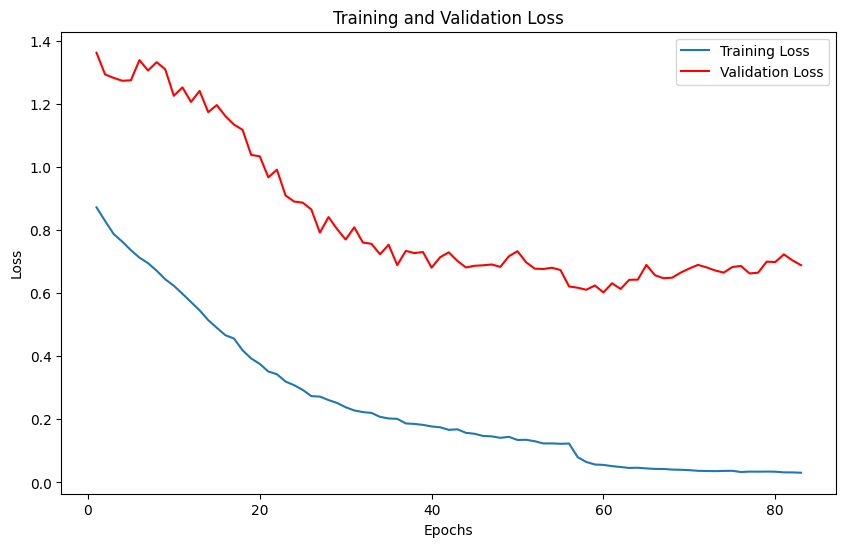

In [13]:
import matplotlib.pyplot as plt


epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, valid_losses, color='red', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
# import torch.nn.functional as F

# class BeamSearchNode(object):
#     def __init__(self, hidden, previousNode, wordId, logProb, length):
#         self.hidden = hidden
#         self.prevNode = previousNode
#         self.wordid = wordId
#         self.logp = logProb
#         self.length = length

#     def eval(self, alpha=1.0):
#         reward = 0
#         return self.logp / float(self.length - 1 + 1e-6) + alpha * reward

# def beam_search(model, src, beam_width=10, max_len=50):
#     src = src.to(device)
#     src = src.unsqueeze(1)  # [src_len, 1] for a single example

#     with torch.no_grad():
#         encoder_outputs, hidden, cell = model.encoder(src)


#     # Starting Node - hidden state, previous node, word id, log prob, length
#     start_node = BeamSearchNode(hidden, None, [formula_vocab["<sos>"]], 0, 1)
#     nodes = [start_node]

#     # Start beam search
#     for _ in range(max_len):
#         new_nodes = []
#         for node in nodes:
#             input = torch.LongTensor([node.wordid[-1]]).to(device)
#             with torch.no_grad():
#                 output, hidden, cell = model.decoder(input, node.hidden, cell)
#                 log_probs = F.log_softmax(output, dim=1)

#             top_log_probs, top_idx = log_probs.topk(beam_width)
#             for i in range(beam_width):
#                 word_idx = top_idx[0][i].item()
#                 log_prob = top_log_probs[0][i].item()

#                 new_node = BeamSearchNode(hidden, node, node.wordid + [word_idx], node.logp + log_prob, node.length + 1)
#                 new_nodes.append(new_node)

#         # Sort nodes by log probability
#         nodes = sorted(new_nodes, key=lambda node: node.logp, reverse=True)[:beam_width]

#     # Find the path with the highest probability
#     end_node = nodes[0]
#     output_sequence = end_node.wordid

#     # Convert indices to tokens
#     # output_tokens = [list(formula_vocab.keys())[list(formula_vocab.values()).index(i)] for i in output_sequence]
#     output_tokens = []
#     for i in output_sequence:
#         if i == 3:  # The value at which you want to break
#             break
#         if i==2:
#           continue
#         else:
#           output_tokens.append(list(formula_vocab.keys())[list(formula_vocab.values()).index(i)])


#     return output_tokens



# # "Problem": "there are 10 girls and 20 boys in a classroom . what is the ratio of girls to boys ?",
# # 		"linear_formula": "divide(n0,n1)"
# problem_text ="120 is what percent of 50 ?"

# src = text_to_indices(problem_text, problem_vocab)
# src_tensor = torch.LongTensor(src)
# # Assuming src is your input tensor for a single example
# # Adjust the `src_field` and `trg_field` to your problem and formula vocab dictionaries
# output_tokens = beam_search(model, src_tensor)
# # Convert indices to tokens
# # output_tokens = [trg_field.vocab.itos[i] for i in result]
# str=""
# for tok in output_tokens:
#   str+=tok
# print(str)


add(n0,const_100


In [16]:
import torch
import torch.nn.functional as F

class BeamSearchNode(object):
    def __init__(self, hidden, previousNode, wordId, logProb, length):
        self.hidden = hidden
        self.prevNode = previousNode
        self.wordid = wordId
        self.logp = logProb
        self.length = length

    def eval(self, alpha=1.0):
        reward = 0
        # Adjust the length penalty
        return self.logp / float(self.length - 1+ 1e-6) + alpha * reward

def beam_search(model, src, beam_width=10, max_len=50):
    src = src.to(device)
    src = src.unsqueeze(1)  # [src_len, 1] for a single example

    with torch.no_grad():
        encoder_outputs, hidden, cell = model.encoder(src)

    # Starting Node - hidden state, previous node, word id, log prob, length
    start_node = BeamSearchNode((hidden, cell), None, [formula_vocab["<sos>"]], 0, 1)
    nodes = [start_node]

    # Start beam search
    for _ in range(max_len):
        new_nodes = []
        for node in nodes:
            input = torch.LongTensor([node.wordid[-1]]).to(device)
            hidden, cell = node.hidden  # Unpack hidden state

            with torch.no_grad():
                # Make sure to pass encoder_outputs for attention mechanism
                output, hidden, cell = model.decoder(input, hidden, cell)
                log_probs = F.log_softmax(output, dim=1)

            top_log_probs, top_idx = log_probs.topk(beam_width)
            for i in range(beam_width):
                word_idx = top_idx[0][i].item()
                log_prob = top_log_probs[0][i].item()

                new_node = BeamSearchNode((hidden, cell), node, node.wordid + [word_idx], node.logp + log_prob, node.length + 1)
                new_nodes.append(new_node)

        # Sort nodes by log probability
        nodes = sorted(new_nodes, key=lambda node: node.logp, reverse=True)[:beam_width]

    # Find the path with the highest probability
    end_node = nodes[0]
    output_sequence = end_node.wordid

    # Convert indices to tokens
    output_tokens = []
    for i in output_sequence:
        if i == formula_vocab["<eos>"]: 
            break
        elif i == formula_vocab["<sos>"]:
            continue
        else:
            output_tokens.append(list(formula_vocab.keys())[list(formula_vocab.values()).index(i)])

    return output_tokens


# "Problem": "there are 10 girls and 20 boys in a classroom . what is the ratio of girls to boys ?",
# 		"linear_formula": "divide(n0,n1)"
problem_text =  "a man can swim in still water at 4.5 km / h , but takes twice as long to swim upstream than downstream . the speed of the stream is ?"
tokens = word_tokenize(problem_text.lower())

# Updated token to index conversion considering "<digit>"
# src = [problem_vocab["<digit>"] if token.isdigit() else problem_vocab.get(token, problem_vocab["<unk>"]) for token in tokens]
src = text_to_indices(problem_text, problem_vocab)

# Convert the list of indices to a PyTorch tensor
src_tensor = torch.LongTensor(src)

output_tokens = beam_search(model, src_tensor)
# Convert indices to tokens
# output_tokens = [trg_field.vocab.itos[i] for i in result]
str=""
for tok in output_tokens:
  str+=tok
print(str)

divide(n0,const_3)|add(#0,const_60)|divide(#1,const_3)|


In [ ]:
# Load the model
# model= torch.load('/content/drive/MyDrive/Colab_Notebooks/final_model.pt')
# model = model.to(device)
# import torch

model = model.to(device)  # Move the model to the appropriate device


for entry in test_data:
   
    problem_text = entry["Problem"]  

    # tokenized_problems = [text_to_indices(item["Problem"], problem_vocab) for item in data]

    src = text_to_indices(problem_text, problem_vocab)
    src_tensor = torch.LongTensor(src)

    # Beam search with BERT model
    output_tokens = beam_search(model, src_tensor)

    str=""
    for tok in output_tokens:
      str+=tok
    entry["predicted"] = str

    with open('test_predictions_part_1.json', 'w') as f_out:
        json.dump(test_data, f_out, indent=4) 

In [ ]:


model = model.to(device)  


for entry in val_data:
   
    problem_text = entry["Problem"] 

    # tokenized_problems = [text_to_indices(item["Problem"], problem_vocab) for item in data]

    src = text_to_indices(problem_text, problem_vocab)
    src_tensor = torch.LongTensor(src)

    # Beam search with BERT model
    output_tokens = beam_search(model, src_tensor)

    str=""
    for tok in output_tokens:
      str+=tok
    entry["predicted"] = str

    with open('valid_predictions_part_1.json', 'w') as f_out:
        json.dump(val_data, f_out, indent=4)  

In [ ]:
train_losses

0.04212323077503712

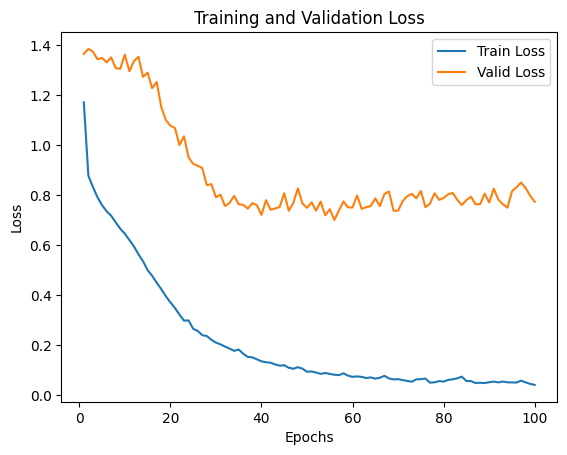

In [ ]:
import matplotlib.pyplot as plt

plt.plot(range(1, N_EPOCHS+1), train_losses, label='Train Loss')
plt.plot(range(1, N_EPOCHS+1), valid_losses, label='Valid Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
